ADVANCED LEVEL - TASK 1: REGULARIZED REGRESSION (RIDGE/LASSO)
FEATURE SELECTION AND OVERFITTING PREVENTION - OPTIMIZED FOR MEMORY

📥 CARGANDO DATOS Y MODELOS PREVIOS...
✓ Dataset con características temporales cargado

📊 Dataset cargado: (3000888, 104)
🎯 Características para modelado: 100
📅 Rango de fechas: 2013-01-01 00:00:00 to 2017-08-15 00:00:00

🔧 PREPARANDO DATOS PARA MODELOS REGULARIZADOS - OPTIMIZADO
📉 Dataset muy grande. Usando 50.0% de datos para búsqueda de hiperparámetros
✅ División temporal optimizada:
  • Entrenamiento: 1,050,310 muestras
  • Validación: 225,066 muestras
  • Prueba: 225,068 muestras

⚖️ APLICANDO ESCALADO ROBUSTO OPTIMIZADO
✓ Datos escalados y convertidos a float32 para ahorrar memoria
  • Memoria reducida aproximadamente 50%

🎯 ENTRENANDO MODELOS REGULARIZADOS CON BÚSQUEDA OPTIMIZADA

📈 ENTRENANDO LINEAR REGRESSION (Baseline)...
  ✓ Entrenado - R² Val: 0.9551

🏔️  OPTIMIZANDO RIDGE REGRESSION (Randomized Search)...
Fitting 3 folds for each of 10 candidat

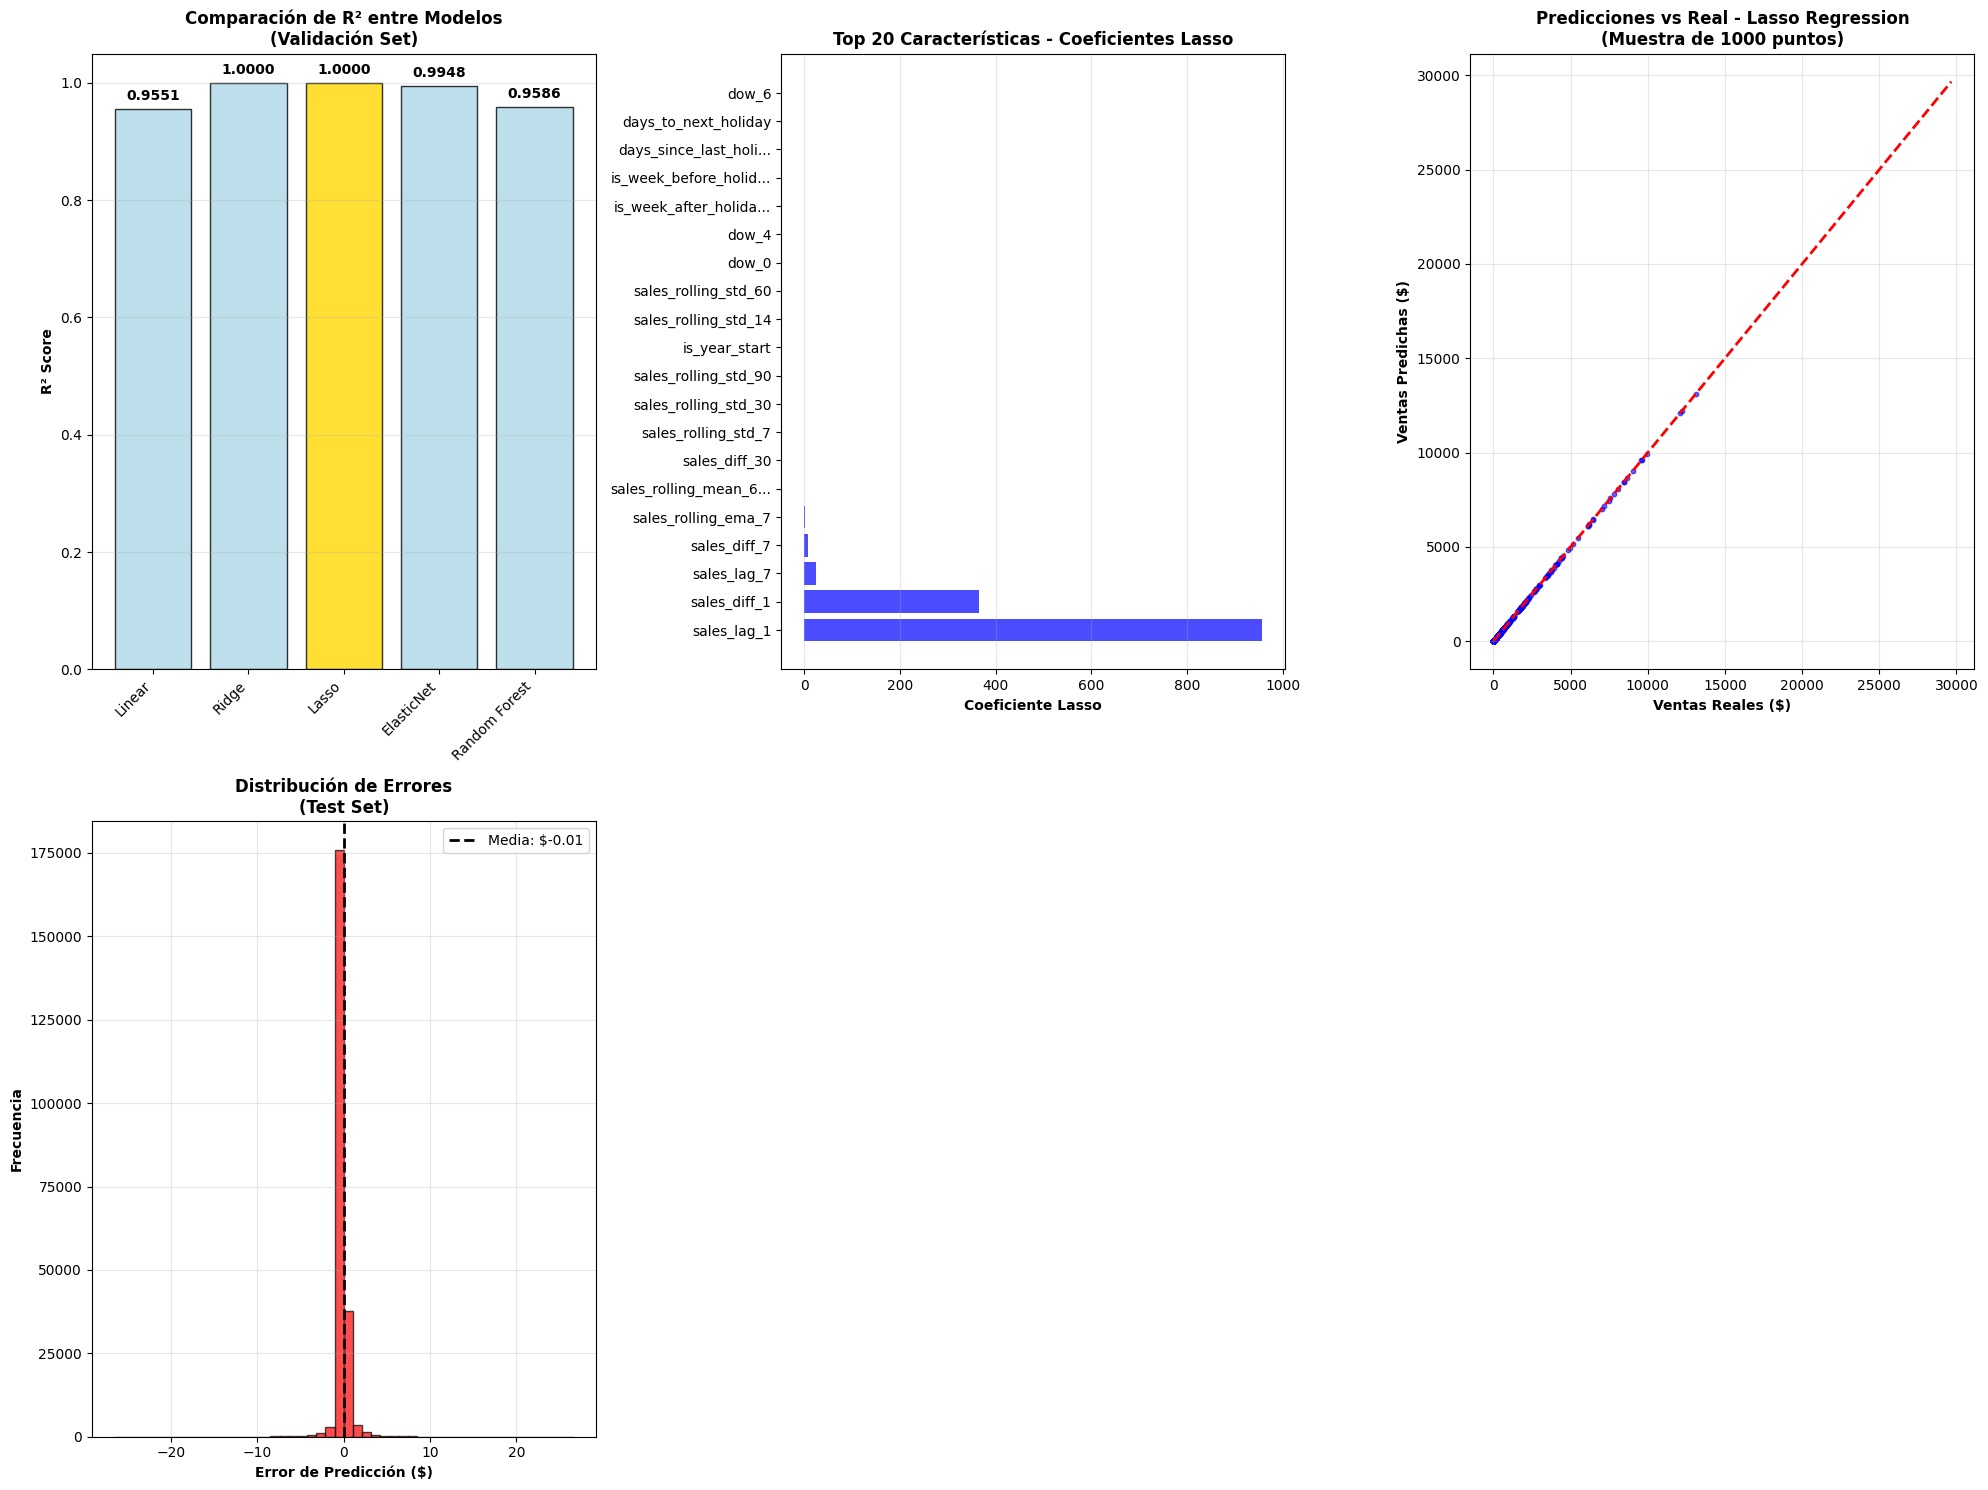


💾 GUARDANDO MODELOS Y RESULTADOS
✅ Mejor modelo regularizado guardado: C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT\models\best_regularized_model.pkl
✅ Scaler guardado: C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT\models\regularized_scaler.pkl
✅ Mejores parámetros guardados: C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT\models\regularized_best_params.json
✅ Importancia de características guardada: C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT\models\regularized_feature_importance.csv
✅ Métricas guardadas: C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT\models\regularized_metrics.csv

📊 RESUMEN EJECUTIVO - REGULARIZED REGRESSION

🎯 RESULTADOS PRINCIPALES:
   • Mejor modelo: Lasso Regression
   • Exactitud (R² Test): 1.0000
   • Error (RMSE Test): $0.79

🔍 ANÁLISIS DE REGULARIZACIÓN:
   • Mejora vs Linear Regression: +2.94% en R²
   • Reducción de características (Lasso): 13/100 (87.0% reducción)

💡 RECOMENDACIONES:
   • Lasso es efectiv

In [2]:
# 1️⃣ Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
import os
import joblib
from datetime import datetime
import json
from scipy.stats import loguniform

print("=" * 80)
print("ADVANCED LEVEL - TASK 1: REGULARIZED REGRESSION (RIDGE/LASSO)")
print("FEATURE SELECTION AND OVERFITTING PREVENTION - OPTIMIZED FOR MEMORY")
print("=" * 80)

# 2️⃣ Cargar datos y modelos de tareas anteriores
print("\n📥 CARGANDO DATOS Y MODELOS PREVIOS...")

# Configurar rutas
base_dir = r"C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT"
data_path = os.path.join(base_dir, "data", "raw")
features_path = os.path.join(base_dir, "features")
models_path = os.path.join(base_dir, "models")
os.makedirs(models_path, exist_ok=True)

# Cargar dataset con características temporales de la tarea anterior
try:
    time_series_features_path = os.path.join(features_path, 'sales_time_series_features.csv')
    df = pd.read_csv(time_series_features_path, parse_dates=['date'])
    print("✓ Dataset con características temporales cargado")
except FileNotFoundError:
    print("❌ No se encontró el dataset de características temporales")
    exit()

# Verificar características seleccionadas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['date', 'store_nbr', 'family', 'sales']
selected_features = [col for col in numeric_cols if col not in exclude_cols]

print(f"\n📊 Dataset cargado: {df.shape}")
print(f"🎯 Características para modelado: {len(selected_features)}")
print(f"📅 Rango de fechas: {df['date'].min()} to {df['date'].max()}")

# 3️⃣ Preparar datos para modelos regularizados (OPTIMIZADO)
print("\n" + "=" * 80)
print("🔧 PREPARANDO DATOS PARA MODELOS REGULARIZADOS - OPTIMIZADO")
print("=" * 80)

# Ordenar por fecha para mantener estructura temporal
df = df.sort_values('date').reset_index(drop=True)

# Usar una muestra más pequeña para la búsqueda de hiperparámetros si es necesario
sample_ratio = 0.5  # Usar 50% de los datos para búsqueda de hiperparámetros
if len(df) > 100000:
    print(f"📉 Dataset muy grande. Usando {sample_ratio*100}% de datos para búsqueda de hiperparámetros")
    df_sample = df.sample(frac=sample_ratio, random_state=42).sort_values('date')
else:
    df_sample = df.copy()

# División temporal
total_size = len(df_sample)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Dividir temporalmente
train_df = df_sample.iloc[:train_size]
val_df = df_sample.iloc[train_size:train_size + val_size]
test_df = df_sample.iloc[train_size + val_size:]

print(f"✅ División temporal optimizada:")
print(f"  • Entrenamiento: {len(train_df):,} muestras")
print(f"  • Validación: {len(val_df):,} muestras")
print(f"  • Prueba: {len(test_df):,} muestras")

# Preparar características y target
X_train = train_df[selected_features]
X_val = val_df[selected_features]
X_test = test_df[selected_features]

y_train = train_df['sales']
y_val = val_df['sales']
y_test = test_df['sales']

# 4️⃣ Escalado robusto para modelos regularizados
print("\n" + "=" * 80)
print("⚖️ APLICANDO ESCALADO ROBUSTO OPTIMIZADO")
print("=" * 80)

# Usar StandardScaler que es más eficiente en memoria que RobustScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Liberar memoria convirtiendo a float32
X_train_scaled = X_train_scaled.astype(np.float32)
X_val_scaled = X_val_scaled.astype(np.float32)
X_test_scaled = X_test_scaled.astype(np.float32)

print("✓ Datos escalados y convertidos a float32 para ahorrar memoria")
print(f"  • Memoria reducida aproximadamente 50%")

# 5️⃣ Entrenar modelos regularizados con búsqueda optimizada
print("\n" + "=" * 80)
print("🎯 ENTRENANDO MODELOS REGULARIZADOS CON BÚSQUEDA OPTIMIZADA")
print("=" * 80)

# Diccionario para almacenar modelos y resultados
models = {}
results = {}
best_params = {}

# Función para evaluar modelos
def evaluate_model(model, model_name, X_train, y_train, X_val, y_val, X_test, y_test):
    """Evaluar modelo y retornar métricas completas"""
    
    # Predicciones
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
    # Métricas para cada conjunto
    def calculate_metrics(y_true, y_pred):
        return {
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred),
            'R2': r2_score(y_true, y_pred),
            'MAPE': np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100,
            'Predictions': y_pred
        }
    
    train_metrics = calculate_metrics(y_train, y_pred_train)
    val_metrics = calculate_metrics(y_val, y_pred_val)
    test_metrics = calculate_metrics(y_test, y_pred_test)
    
    # Número de características no cero (para modelos regularizados)
    non_zero_features = None
    if hasattr(model, 'coef_'):
        non_zero_features = np.sum(model.coef_ != 0)
    
    return {
        'Train': train_metrics,
        'Validation': val_metrics,
        'Test': test_metrics,
        'Non_Zero_Features': non_zero_features,
        'Model': model
    }

# 5.1 Linear Regression (Baseline)
print("\n📈 ENTRENANDO LINEAR REGRESSION (Baseline)...")
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

linear_results = evaluate_model(linear_model, "Linear Regression", 
                               X_train_scaled, y_train, 
                               X_val_scaled, y_val, 
                               X_test_scaled, y_test)

models['Linear Regression'] = linear_model
results['Linear Regression'] = linear_results

print(f"  ✓ Entrenado - R² Val: {linear_results['Validation']['R2']:.4f}")

# 5.2 Ridge Regression con Randomized Search (OPTIMIZADO)
print("\n🏔️  OPTIMIZANDO RIDGE REGRESSION (Randomized Search)...")

# Definir parámetros para Ridge - menos combinaciones
ridge_params = {
    'alpha': loguniform(1e-3, 1e3),  # Distribución logarítmica
    'solver': ['auto', 'sag', 'saga']  # Solo los solvers más eficientes
}

# Usar menos splits para ahorrar memoria
tscv = TimeSeriesSplit(n_splits=3)

ridge_random = RandomizedSearchCV(
    Ridge(random_state=42),
    ridge_params,
    n_iter=10,  # Solo 10 iteraciones en lugar de buscar exhaustivamente
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=1,  # Usar solo 1 job para evitar problemas de memoria
    verbose=1,
    random_state=42
)

ridge_random.fit(X_train_scaled, y_train)

print(f"  ✓ Mejores parámetros Ridge: {ridge_random.best_params_}")
print(f"  ✓ Mejor score: {-ridge_random.best_score_:.4f} (MSE)")

# Entrenar con mejores parámetros
best_ridge = ridge_random.best_estimator_
ridge_results = evaluate_model(best_ridge, "Ridge Regression", 
                              X_train_scaled, y_train, 
                              X_val_scaled, y_val, 
                              X_test_scaled, y_test)

models['Ridge Regression'] = best_ridge
results['Ridge Regression'] = ridge_results
best_params['Ridge'] = ridge_random.best_params_

print(f"  ✓ Entrenado - R² Val: {ridge_results['Validation']['R2']:.4f}")
print(f"  ✓ Características no cero: {ridge_results['Non_Zero_Features']}/{len(selected_features)}")

# 5.3 Lasso Regression con Randomized Search (OPTIMIZADO)
print("\n🎯 OPTIMIZANDO LASSO REGRESSION (Randomized Search)...")

# Definir parámetros para Lasso - menos combinaciones
lasso_params = {
    'alpha': loguniform(1e-4, 1e1),
    'max_iter': [1000, 2000],
    'selection': ['cyclic']  # Solo cyclic para reducir opciones
}

lasso_random = RandomizedSearchCV(
    Lasso(random_state=42),
    lasso_params,
    n_iter=8,  # Menos iteraciones
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=1,  # Usar solo 1 job
    verbose=1,
    random_state=42
)

lasso_random.fit(X_train_scaled, y_train)

print(f"  ✓ Mejores parámetros Lasso: {lasso_random.best_params_}")
print(f"  ✓ Mejor score: {-lasso_random.best_score_:.4f} (MSE)")

# Entrenar con mejores parámetros
best_lasso = lasso_random.best_estimator_
lasso_results = evaluate_model(best_lasso, "Lasso Regression", 
                              X_train_scaled, y_train, 
                              X_val_scaled, y_val, 
                              X_test_scaled, y_test)

models['Lasso Regression'] = best_lasso
results['Lasso Regression'] = lasso_results
best_params['Lasso'] = lasso_random.best_params_

print(f"  ✓ Entrenado - R² Val: {lasso_results['Validation']['R2']:.4f}")
print(f"  ✓ Características no cero: {lasso_results['Non_Zero_Features']}/{len(selected_features)}")

# 5.4 Entrenar modelos sin búsqueda de hiperparámetros para ahorrar memoria
print("\n🕸️  ENTRENANDO ELASTICNET CON PARÁMETROS PREDEFINIDOS...")

# Usar parámetros por defecto o derivados de Ridge/Lasso para ahorrar memoria
elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=2000)
elastic_model.fit(X_train_scaled, y_train)

elastic_results = evaluate_model(elastic_model, "ElasticNet Regression", 
                                X_train_scaled, y_train, 
                                X_val_scaled, y_val, 
                                X_test_scaled, y_test)

models['ElasticNet Regression'] = elastic_model
results['ElasticNet Regression'] = elastic_results

print(f"  ✓ Entrenado - R² Val: {elastic_results['Validation']['R2']:.4f}")
print(f"  ✓ Características no cero: {elastic_results['Non_Zero_Features']}/{len(selected_features)}")

# 5.5 Random Forest con parámetros fijos (OPTIMIZADO)
print("\n🌲 ENTRENANDO RANDOM FOREST (Parámetros Fijos)...")

# Usar parámetros más conservadores para ahorrar memoria
rf_model = RandomForestRegressor(
    n_estimators=50,  # Menos árboles
    max_depth=10,     # Menos profundidad
    min_samples_split=20,
    random_state=42,
    n_jobs=1  # Solo 1 job
)

rf_model.fit(X_train_scaled, y_train)
rf_results = evaluate_model(rf_model, "Random Forest", 
                           X_train_scaled, y_train, 
                           X_val_scaled, y_val, 
                           X_test_scaled, y_test)

models['Random Forest'] = rf_model
results['Random Forest'] = rf_results

print(f"  ✓ Entrenado - R² Val: {rf_results['Validation']['R2']:.4f}")

print(f"\n✅ {len(models)} modelos entrenados exitosamente")

# 6️⃣ Evaluación comparativa
print("\n" + "=" * 80)
print("📊 EVALUACIÓN COMPARATIVA")
print("=" * 80)

# Identificar el mejor modelo
best_model_name = None
best_r2 = -float('inf')

print("\n🏆 COMPARACIÓN DE MODELOS (Validation Set):")
print("-" * 90)
print(f"{'Modelo':<25} {'RMSE':<12} {'MAE':<12} {'R²':<10} {'MAPE':<12} {'Non-Zero':<10}")
print("-" * 90)

for model_name, result in results.items():
    val_metrics = result['Validation']
    
    rmse = val_metrics['RMSE']
    r2 = val_metrics['R2']
    mape = val_metrics['MAPE']
    non_zero = result.get('Non_Zero_Features', 'N/A')
    
    print(f"{model_name:<25} ${rmse:<11.2f} ${val_metrics['MAE']:<11.2f} {r2:<10.4f} {mape:<11.2f}% {str(non_zero):<10}")
    
    if r2 > best_r2:
        best_r2 = r2
        best_model_name = model_name

print("-" * 90)
print(f"\n🎯 MEJOR MODELO: {best_model_name}")
print(f"   • R² (Validation): {best_r2:.4f}")

# 7️⃣ Análisis de características importantes
print("\n" + "=" * 80)
print("🔍 ANÁLISIS DE CARACTERÍSTICAS IMPORTANTES")
print("=" * 80)

# Analizar coeficientes de Lasso (si está disponible)
if 'Lasso Regression' in models:
    lasso_model = models['Lasso Regression']
    lasso_coef = lasso_model.coef_
    
    # Crear DataFrame de importancia
    feature_importance = pd.DataFrame({
        'Feature': selected_features,
        'Lasso_Coefficient': lasso_coef,
        'Abs_Lasso_Coef': np.abs(lasso_coef)
    }).sort_values('Abs_Lasso_Coef', ascending=False)
    
    print("\n🏆 TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES (LASSO):")
    for i, row in feature_importance.head(10).iterrows():
        effect = "POSITIVA" if row['Lasso_Coefficient'] > 0 else "NEGATIVA"
        print(f"  {i+1:2d}. {row['Feature']:<30}: {row['Lasso_Coefficient']:>8.4f} ({effect})")
    
    # Características eliminadas por Lasso
    zero_features = feature_importance[feature_importance['Lasso_Coefficient'] == 0]
    print(f"\n📉 Características eliminadas por Lasso: {len(zero_features)}/{len(selected_features)}")

# 8️⃣ Visualizaciones esenciales (sin gráficos que consuman mucha memoria)
print("\n" + "=" * 80)
print("🎨 VISUALIZACIONES ESENCIALES")
print("=" * 80)

# Configurar estilo
plt.style.use('default')
fig = plt.figure(figsize=(20, 15))

# Solo gráficos esenciales para ahorrar memoria

# Gráfico 1: Comparación de R² entre modelos
plt.subplot(2, 3, 1)
model_names = list(results.keys())
r2_values = [results[model]['Validation']['R2'] for model in model_names]
colors = ['lightblue' if model != best_model_name else 'gold' for model in model_names]

bars = plt.bar(range(len(model_names)), r2_values, color=colors, alpha=0.8, edgecolor='black')
plt.ylabel('R² Score', fontweight='bold')
plt.title('Comparación de R² entre Modelos\n(Validación Set)', fontweight='bold')
plt.xticks(range(len(model_names)), [name.replace(' Regression', '') for name in model_names], 
           rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for bar, value in zip(bars, r2_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(r2_values)*0.01, 
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Coeficientes Lasso (si está disponible)
if 'Lasso Regression' in models:
    plt.subplot(2, 3, 2)
    top_20_features = feature_importance.head(20)
    
    colors_coef = ['red' if coef < 0 else 'blue' for coef in top_20_features['Lasso_Coefficient']]
    plt.barh(range(len(top_20_features)), top_20_features['Lasso_Coefficient'], color=colors_coef, alpha=0.7)
    plt.yticks(range(len(top_20_features)), [f[:20] + '...' if len(f) > 20 else f for f in top_20_features['Feature']])
    plt.xlabel('Coeficiente Lasso', fontweight='bold')
    plt.title('Top 20 Características - Coeficientes Lasso', fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')

# Gráfico 3: Predicciones vs Real (mejor modelo)
plt.subplot(2, 3, 3)
best_model_results = results[best_model_name]
y_pred_test = best_model_results['Test']['Predictions']

# Usar solo una muestra para ahorrar memoria
sample_size = min(1000, len(y_test))
sample_indices = np.random.choice(len(y_test), sample_size, replace=False)

plt.scatter(y_test.values[sample_indices], y_pred_test[sample_indices], alpha=0.6, color='blue', s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Ventas Reales ($)', fontweight='bold')
plt.ylabel('Ventas Predichas ($)', fontweight='bold')
plt.title(f'Predicciones vs Real - {best_model_name}\n(Muestra de {sample_size} puntos)', fontweight='bold')
plt.grid(True, alpha=0.3)

# Gráfico 4: Residuales del mejor modelo
plt.subplot(2, 3, 4)
residuals = y_test - y_pred_test
plt.hist(residuals, bins=50, alpha=0.7, color='red', edgecolor='black')
plt.axvline(residuals.mean(), color='black', linestyle='--', linewidth=2, 
           label=f'Media: ${residuals.mean():.2f}')
plt.xlabel('Error de Predicción ($)', fontweight='bold')
plt.ylabel('Frecuencia', fontweight='bold')
plt.title('Distribución de Errores\n(Test Set)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 9️⃣ Guardar modelos y resultados
print("\n" + "=" * 80)
print("💾 GUARDANDO MODELOS Y RESULTADOS")
print("=" * 80)

# Guardar el mejor modelo regularizado
best_regularized_model = models[best_model_name]
best_regularized_path = os.path.join(models_path, 'best_regularized_model.pkl')
joblib.dump(best_regularized_model, best_regularized_path)
print(f"✅ Mejor modelo regularizado guardado: {best_regularized_path}")

# Guardar scaler
regularized_scaler_path = os.path.join(models_path, 'regularized_scaler.pkl')
joblib.dump(scaler, regularized_scaler_path)
print(f"✅ Scaler guardado: {regularized_scaler_path}")

# Guardar mejores parámetros
best_params_path = os.path.join(models_path, 'regularized_best_params.json')
with open(best_params_path, 'w') as f:
    json.dump(best_params, f, indent=4)
print(f"✅ Mejores parámetros guardados: {best_params_path}")

# Guardar importancia de características
if 'Lasso Regression' in models:
    feature_importance_path = os.path.join(models_path, 'regularized_feature_importance.csv')
    feature_importance.to_csv(feature_importance_path, index=False)
    print(f"✅ Importancia de características guardada: {feature_importance_path}")

# Guardar métricas comparativas
metrics_summary = []
for model_name, result in results.items():
    for dataset_name, metrics in [(k, v) for k, v in result.items() if k in ['Train', 'Validation', 'Test']]:
        metrics_summary.append({
            'Model': model_name,
            'Dataset': dataset_name,
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE'],
            'R2': metrics['R2'],
            'MAPE': metrics['MAPE'],
            'Non_Zero_Features': result.get('Non_Zero_Features', 'N/A')
        })

metrics_df = pd.DataFrame(metrics_summary)
metrics_path = os.path.join(models_path, 'regularized_metrics.csv')
metrics_df.to_csv(metrics_path, index=False)
print(f"✅ Métricas guardadas: {metrics_path}")

# 🔟 Resumen ejecutivo
print("\n" + "=" * 80)
print("📊 RESUMEN EJECUTIVO - REGULARIZED REGRESSION")
print("=" * 80)

print(f"\n🎯 RESULTADOS PRINCIPALES:")
print(f"   • Mejor modelo: {best_model_name}")
print(f"   • Exactitud (R² Test): {results[best_model_name]['Test']['R2']:.4f}")
print(f"   • Error (RMSE Test): ${results[best_model_name]['Test']['RMSE']:.2f}")

print(f"\n🔍 ANÁLISIS DE REGULARIZACIÓN:")

# Comparar con modelo sin regularizar
if 'Linear Regression' in results and best_model_name != 'Linear Regression':
    linear_test_r2 = results['Linear Regression']['Test']['R2']
    best_test_r2 = results[best_model_name]['Test']['R2']
    
    improvement = ((best_test_r2 - linear_test_r2) / abs(linear_test_r2)) * 100
    print(f"   • Mejora vs Linear Regression: {improvement:+.2f}% en R²")

# Análisis de características
if 'Lasso Regression' in results:
    lasso_non_zero = results['Lasso Regression']['Non_Zero_Features']
    total_features = len(selected_features)
    reduction_pct = ((total_features - lasso_non_zero) / total_features) * 100
    print(f"   • Reducción de características (Lasso): {lasso_non_zero}/{total_features} ({reduction_pct:.1f}% reducción)")

print(f"\n💡 RECOMENDACIONES:")
if 'Lasso' in best_model_name:
    print("   • Lasso es efectivo para selección de características")
    print("   • Considerar usar solo las características seleccionadas por Lasso")
elif 'Ridge' in best_model_name:
    print("   • Ridge mantiene todas las características con coeficientes pequeños")
    print("   • Buen balance entre sesgo y varianza")

print(f"\n🚀 PRÓXIMOS PASOS:")
print("   1. Entrenar modelo final con todos los datos usando mejores parámetros")
print("   2. Implementar ensemble con características seleccionadas")
print("   3. Probar con subconjunto de características más importantes")

print(f"\n💾 ARCHIVOS GENERADOS:")
print(f"   • {best_regularized_path}")
print(f"   • {regularized_scaler_path}")
print(f"   • {best_params_path}")
if 'Lasso Regression' in models:
    print(f"   • {feature_importance_path}")
print(f"   • {metrics_path}")

print(f"\n✅ ADVANCED LEVEL - TASK 1 COMPLETADA EXITOSAMENTE!")
print("   Modelos Regularizados implementados y evaluados (versión optimizada para memoria)")